In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# Paths
classification_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\classification_dataset"

In [2]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load dataset
def load_classification_data(directory):
    images = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith((".jpg", ".png", ".jpeg")):
            label = int(file.split('_')[1][0])  # Extract label (0 or 1)
            img_path = os.path.join(directory, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load data
X, y = load_classification_data(classification_dir)

# Shuffle dataset
X, y = shuffle(X, y, random_state=42)

C:\Users\Salem Shamsul Alam\AppData\Local\Temp\ipykernel_5292\1763487380.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


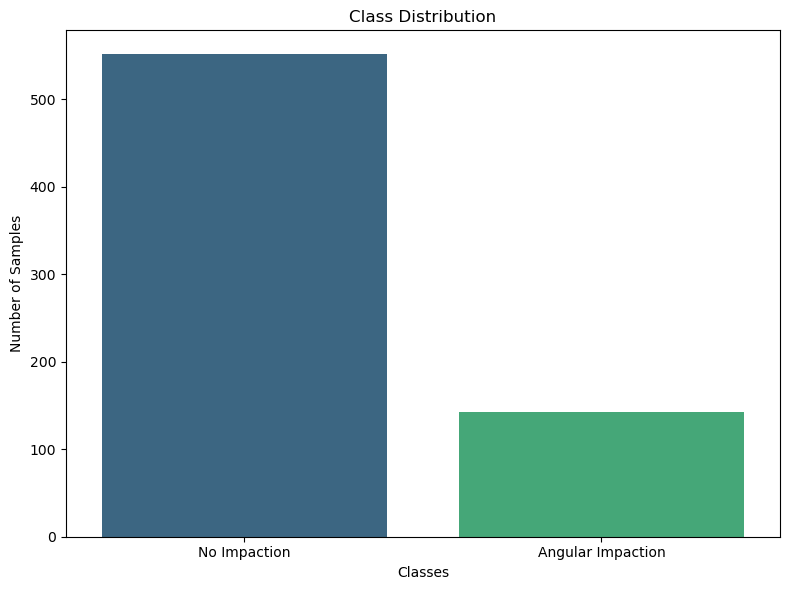

In [3]:
# Exploratory Data Analysis: Class distribution
def plot_class_distribution(labels, save_path="class_distribution.png"):
    unique, counts = np.unique(labels, return_counts=True)
    class_names = ["No Impaction", "Angular Impaction"]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

plot_class_distribution(y)

In [4]:
# Train-validation-test split (8:1:1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Apply Random Over Sampler
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape((X_train.shape[0], -1))  # Flatten for oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape((-1, IMG_SIZE[0], IMG_SIZE[1], 3))  # Reshape back


Training set shape: (554, 224, 224, 3), (554,)
Validation set shape: (69, 224, 224, 3), (69,)
Test set shape: (70, 224, 224, 3), (70,)


In [5]:
# Build CNN model
def build_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()

D:\CSE299\Flutter\Anaconda\envs\Research\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(

)
datagen.fit(X_train_resampled)


In [7]:
# Train the model
history = model.fit(
    datagen.flow(X_train_resampled, y_train_resampled, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=20
)

Epoch 1/20


D:\CSE299\Flutter\Anaconda\envs\Research\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5163 - loss: 0.8625 - val_accuracy: 0.2174 - val_loss: 0.7143
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5058 - loss: 0.6925 - val_accuracy: 0.3768 - val_loss: 0.7180
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5779 - loss: 0.6718 - val_accuracy: 0.6667 - val_loss: 0.6237
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6665 - loss: 0.6343 - val_accuracy: 0.5217 - val_loss: 0.7096
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6698 - loss: 0.6076 - val_accuracy: 0.6377 - val_loss: 0.7027
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6830 - loss: 0.5606 - val_accuracy: 0.6522 - val_loss: 0.6442
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6671 - loss: 0.5724 - val_accuracy: 0.7391 - val_loss: 0.7366
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7656 - loss: 0.4671 - val_accuracy: 0.7826 - val_loss: 0.8644
Epo

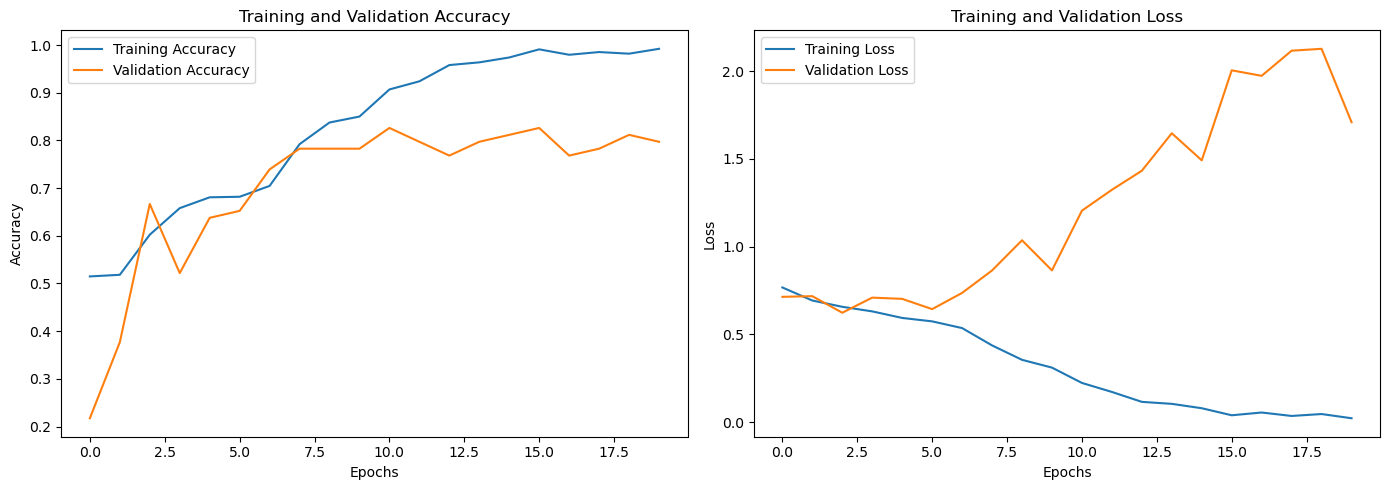

In [8]:
# Plot Accuracy and Loss Curves
def plot_training_curves(history):
    plt.figure(figsize=(14, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

In [9]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Impaction", "Angular Impaction"]))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
Classification Report:
                   precision    recall  f1-score   support

     No Impaction       0.84      0.86      0.85        56
Angular Impaction       0.38      0.36      0.37        14

         accuracy                           0.76        70
        macro avg       0.61      0.61      0.61        70
     weighted avg       0.75      0.76      0.75        70



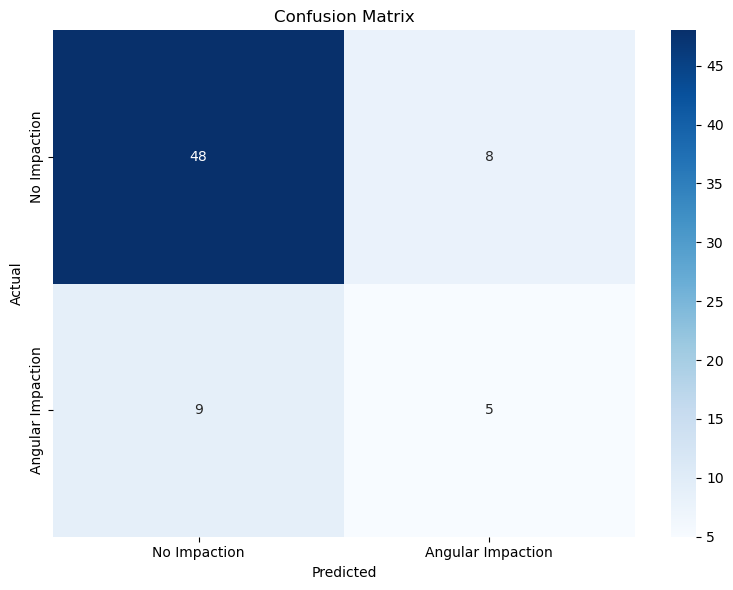

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Impaction", "Angular Impaction"], yticklabels=["No Impaction", "Angular Impaction"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

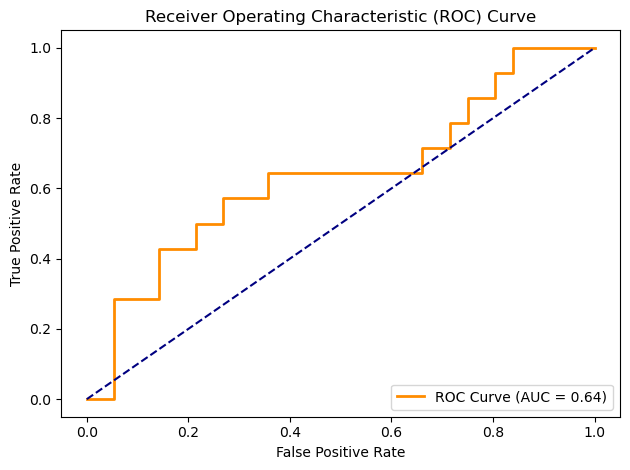

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()